In [1]:
import os 
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
sys.path.append("../../utilities/")
import data_utils
import evaluation_utils

In [39]:
resolution = 100000

valid_bins = pd.read_csv("../../data/valid_bins/K562_100000_bins.txt", sep = "\t", header = None)
valid_bins.columns = ['chr_name', 'start', 'end', 'index']
valid_bins['pos'] = [int(p/100000) for p in valid_bins['start']]
valid_bins = valid_bins[['chr_name', 'pos']]
valid_pos = {}
valid_pos['chr21'] = valid_bins[valid_bins['chr_name'] == 'chr21']['pos'].values
valid_pos['chr22'] = valid_bins[valid_bins['chr_name'] == 'chr22']['pos'].values

signals = data_utils.create_assays_df('../../data','K562',resolution,['chip','tsa'])
signals_names = signals.columns[2:]

mats = {}

for chr1 in [21,22]:
    first_chr = 'chr' + str(chr1)
    for chr2 in np.arange(chr1,23):
        second_chr = 'chr' + str(chr2)
        mats[first_chr,second_chr] = data_utils.create_matrix("../../data", 'K562', first_chr, second_chr, resolution)
        mats[first_chr,second_chr] = mats[first_chr,second_chr][np.ix_(valid_pos[first_chr],valid_pos[second_chr])]
        
signals_vectors = {}
for chr_name in ['chr21', 'chr22']:
    chr_signals = pd.merge(signals[signals['chr_name']==chr_name], valid_bins, on = ['chr_name', 'pos'], how = 'inner')
    for signal_name in signals_names:
        signals_vectors[chr_name, signal_name] = list(chr_signals[signal_name].values)

In [49]:
for signal_name in signals_names:
    sp_corrs[signal_name] = np.zeros((2,2))
    sp_corrs[signal_name][0,0] = evaluation_utils.spatial_correlation2(
    signals_vectors['chr21',signal_name], signals_vectors['chr21',signal_name],
    mats['chr21','chr21'])
    sp_corrs[signal_name][0,1] = evaluation_utils.spatial_correlation2(
    signals_vectors['chr21',signal_name], signals_vectors['chr22',signal_name],
    mats['chr21','chr22'])
    sp_corrs[signal_name][1,1] = evaluation_utils.spatial_correlation2(
    signals_vectors['chr22',signal_name], signals_vectors['chr22',signal_name],
    mats['chr22','chr22'])

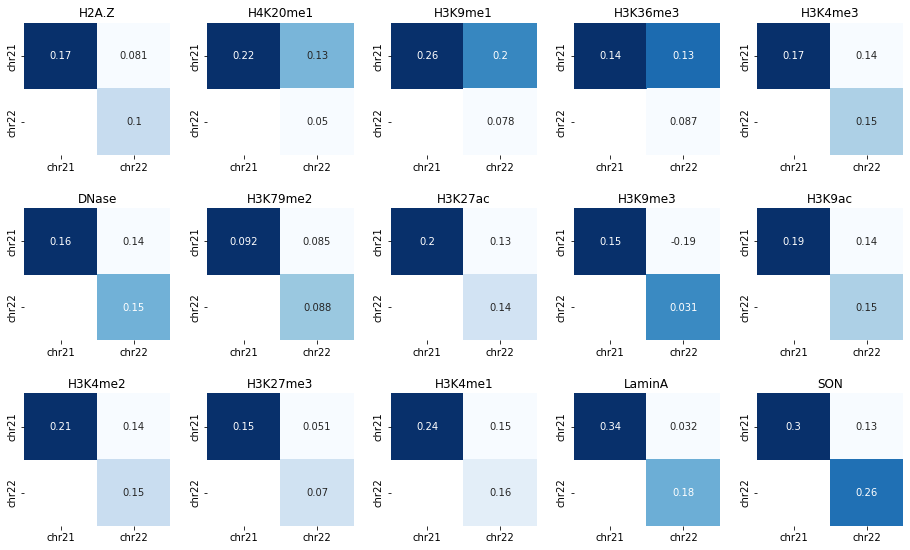

In [67]:
fig, axs = plt.subplots(3,5, figsize = (13,8))
for i, signal_name in enumerate(signals_names):
    row_id = int(i/5)
    col_id = i%5
    sns.heatmap(sp_corrs[signal_name], annot = True, mask = np.tri(2,k=-1), cmap = "Blues", cbar = False, ax = axs[row_id,col_id])
    axs[row_id,col_id].set_xticklabels(['chr21','chr22'])
    axs[row_id,col_id].set_yticklabels(['chr21','chr22'])
    axs[row_id,col_id].set_title(signal_name)
fig.tight_layout(pad=2.0)
plt.show()

In [92]:
TADs = pd.read_csv("../../data/K562/annotations/GSE63525_K562_Arrowhead_domainlist.txt", sep = "\t")
TADs['start'] = [int(s/resolution) for s in TADs['x1']]
TADs['end'] = [int(e/resolution) for e in TADs['x2']]
TADs.rename(columns = {'chr1':'chr_name'}, inplace = True)
TADs = TADs[['chr_name', 'start', 'end']]
TADs.sort_values(by = ['chr_name','start'], inplace = True)

In [95]:
print(np.where(valid_pos['chr21']==173)[0][0])
print(np.where(valid_pos['chr21']==187)[0][0])
print(np.where(valid_pos['chr21']==194)[0][0])
print(np.where(valid_pos['chr21']==208)[0][0])

41
55
62
76


In [99]:
mats['chr21','chr21'][np.ix_(np.arange(41,56),np.arange(41,56))]

array([[1.206758  , 1.1875759 , 1.219627  , 1.526304  , 1.748702  ,
        1.5574133 , 1.7045488 , 1.9344803 , 2.094337  , 2.3477716 ,
        2.6196048 , 2.7299173 , 2.9412634 , 3.3344433 , 3.2417588 ],
       [1.1875759 , 1.2188147 , 1.2839053 , 1.4771682 , 1.5740687 ,
        1.5611628 , 1.6324562 , 1.8225505 , 2.1145256 , 2.1659539 ,
        2.576319  , 2.783835  , 2.8594353 , 3.0783997 , 2.5900865 ],
       [1.219627  , 1.2839053 , 1.3318309 , 1.2057245 , 1.2691867 ,
        1.4656801 , 1.4613447 , 1.7411118 , 1.6732374 , 1.9942116 ,
        2.5654125 , 2.5312722 , 2.8823771 , 3.313852  , 2.2947297 ],
       [1.526304  , 1.4771682 , 1.2057245 , 1.2507645 , 1.1499957 ,
        1.1898034 , 1.406106  , 1.4349762 , 1.561989  , 1.7728866 ,
        2.206222  , 2.2136345 , 2.4843903 , 2.4369426 , 2.1844738 ],
       [1.748702  , 1.5740687 , 1.2691867 , 1.1499957 , 1.1848089 ,
        1.111414  , 1.2462392 , 1.4881372 , 1.6222597 , 1.922933  ,
        1.9304532 , 2.118832  , 2.5660946 , 

In [113]:
l = 0
u = 50
#41-55
TAD_sp_corrs = {}
for signal_name in signals_names:
    TAD_sp_corrs[signal_name] = evaluation_utils.spatial_correlation(signals_vectors['chr21',signal_name][l:u],
                                        mats['chr21','chr21'][np.ix_(np.arange(l,u),np.arange(l,u))])

In [114]:
TAD_sp_corrs

{'H2A.Z': 0.2169998180287328,
 'H4K20me1': 0.11517057615586625,
 'H3K9me1': 0.11981796599816671,
 'H3K36me3': 0.11037986199456583,
 'H3K4me3': 0.14851716523798916,
 'DNase': 0.09709713840629429,
 'H3K79me2': 0.11336123492746257,
 'H3K27ac': 0.1631920821984922,
 'H3K9me3': -0.12919667228487633,
 'H3K9ac': 0.17006377531932745,
 'H3K4me2': 0.1478731779902806,
 'H3K27me3': 0.08379711936752635,
 'H3K4me1': 0.19736334751511966,
 'LaminA': 0.1237245002467605,
 'SON': 0.19328566966120772}